In [1]:
# CONTENTS

# load test data (messages & book)
# select (random) test sequence
# encode msg and book sequence for model

# get raw book data (L2) at the start of the sequence
# init simulator with initial book
# replay sequence in simulator (actual)

# load trained model
# predict next message
# map message to one the simulator understands & is valid
# apply message to simulator (predicted)
# get L2 representation and encode it for model

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"
import torch
torch.multiprocessing.set_start_method('spawn')

In [4]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint

In [5]:
data_dir = '/nfs/home/peern/LOBS5/data/raw/'
save_dir = '/nfs/home/peern/LOBS5/data/'

In [6]:
message_files = sorted(glob(data_dir + '*message*.csv'))
book_files = sorted(glob(data_dir + '*orderbook*.csv'))

In [7]:
# load test data (last day)

m = pd.read_csv(
    message_files[-1],
    names=['time', 'event_type', 'order_id', 'size', 'price', 'direction'],
    index_col=False)

b = pd.read_csv(
    book_files[-1],
    index_col=False,
    header=None
)

# remove diallowed order types
m = m.loc[m.event_type.isin([1, 2, 3, 4])]
b = b.loc[m.index]

/nfs/home/peern/rlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nfs/home/peern/rlenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


## Encoding

In [8]:
# Book encoding
price_levels = 40  # how many ticks to represent

In [9]:
# Message encoding
v = Vocab()
tok = Message_Tokenizer()

In [10]:
# encode from raw data

# print('<< pre processing >>')
# m_proc = tok.preproc(m, b)
# print('<< encoding >>')
# m_enc = tok.encode(m_proc, v)

# instead load from file:
msg_enc_file = sorted(glob(save_dir + '*message*.npy'))[-1]
m_enc = onp.load(msg_enc_file)

In [11]:
# remove first message from raw data as well
m = m.iloc[1:]

In [12]:
m_enc

array([[    3,     3,     8, ...,     2,     2,     2],
       [    3,     3,     8, ...,     2,     2,     2],
       [    3,     3,     9, ...,     2,     2,     2],
       ...,
       [   26,   402,   997, ..., 11108, 11007, 11110],
       [   26,   402,   985, ..., 11108, 11010, 11110],
       [   26,   402,  1002, ...,     2,     2,     2]])

In [13]:
m.shape

(1829106, 6)

In [14]:
# m_proc.shape

In [15]:
m_enc.shape

(1829106, 20)

In [16]:
# encode from raw data:
# b_enc = preproc.process_book(b, price_levels=price_levels)

# instead load from file:
book_enc_file = sorted(glob(save_dir + '*book*.npy'))[-1]
b_enc = onp.load(book_enc_file)

In [17]:
#b_enc_ = preproc.process_book(b, price_levels=price_levels)

In [18]:
b.shape

(1829107, 40)

In [19]:
b_enc.shape

(1829107, 41)

In [20]:
#b_enc_.shape

## Data Initialisation

In [21]:
n_messages = 500

In [22]:
# when to start the prediction
# convert time into seconds after midnight
start_time = (pd.to_datetime('11:00') - pd.to_datetime('00:00')).total_seconds()
# get seq end index
end_i = len(m.loc[m.time < start_time])

In [23]:
m_seq = m_enc[end_i - n_messages : end_i].reshape(-1)  # (n_messages [500] * levels [20], )
# book state: we already include the book state after the last message
# (different to training where we only have the book state before the first message
# and mask part of the last message)
# for message seq, we first need to append an empty message
b_seq = b_enc[end_i - n_messages + 1 : end_i + 1]      # (n_messages [500], price_levels + 1 [41])

## Simulator

In [24]:
os.path.abspath('')

'/nfs/home/peern/LOBS5/lob'

In [25]:
import os
import sys

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(os.path.join(parent_folder_path, submodule_name))

In [26]:
from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderbook as job

2023-05-02 09:24:42.073815: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nfs/home/peern/rlenv/lib/python3.8/site-packages/nvidia/cuda_runtime/lib/:/nfs/home/peern/rlenv/lib/python3.8/site-packages/tensorrt/:/nfs/home/peern/rlenv/lib/python3.8/site-packages/nvidia/cuda_runtime/lib/:/usr/local/cuda-11.2/lib64:
2023-05-02 09:24:42.073861: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [29]:
# TODO: integrate this into simualtor: OrderBook

def init_msgs_from_l2(book: Union[pd.Series, onp.ndarray]) -> jnp.ndarray:
    orderbookLevels = len(book) // 4  # price/quantity for bid/ask
    data = jnp.array(book).reshape(int(orderbookLevels*2),2)
    newarr = jnp.zeros((int(orderbookLevels*2),8))
    initOB = newarr \
        .at[:,3].set(data[:,0]) \
        .at[:,2].set(data[:,1]) \
        .at[:,0].set(1) \
        .at[0:orderbookLevels*4:2,1].set(-1) \
        .at[1:orderbookLevels*4:2,1].set(1) \
        .at[:,4].set(0) \
        .at[:,5].set(job.INITID) \
        .at[:,6].set(34200) \
        .at[:,7].set(0).astype('int32')
    return initOB

def msgs_to_jnp(m_df: pd.DataFrame) -> jnp.ndarray:
    m_df = m_df.copy()
    cols = ['Time', 'Type', 'OrderID', 'Quantity', 'Price', 'Side']
    if m_df.shape[1] == 7:
        cols += ["TradeID"]
    m_df.columns = cols
    m_df['TradeID'] = 0  #  TODO: should be TraderID for multi-agent support
    col_order=['Type','Side','Quantity','Price','TradeID','OrderID','Time']
    m_df = m_df[col_order]
    m_df = m_df[(m_df['Type'] != 6) & (m_df['Type'] != 7) & (m_df['Type'] != 5)]
    time = m_df["Time"].astype('string').str.split('.',expand=True)
    m_df[["TimeWhole","TimeDec"]] = time.astype('int32')
    m_df = m_df.drop("Time", axis=1)
    mJNP = jnp.array(m_df)
    return mJNP

def reset_orderbook(
        b: OrderBook,
        l2_book: Optional[Union[pd.Series, onp.ndarray]] = None,
    ) -> None:
    b.orderbook_array = b.orderbook_array.at[:].set(-1)
    if l2_book is not None:
        msgs = init_msgs_from_l2(l2_book)
        b.process_orders_array(msgs)

In [30]:
sim = OrderBook(price_levels=10, orderQueueLen=20)
sim

In [31]:
# init simulator at the start of the sequence
reset_orderbook(sim, b.iloc[end_i - n_messages])

In [32]:
# replay sequence in simulator (actual)
# so that sim is at the same state as the model
replay = msgs_to_jnp(m.iloc[end_i - n_messages : end_i])
trades = sim.process_orders_array(replay)

In [33]:
sim.get_L2_state()

Array([988100,    182, 987900,    802, 988200,   1056, 987800,    782,
       988300,    706, 987700,    600, 988400,   1100, 987600,    500,
       988500,   1012, 987500,   1250, 988600,    468, 987400,    775,
       988700,   1615, 987300,    490, 988800,    431, 987200,     50,
       989000,     50, 987100,    750,     -1,      0, 987000,     50],      dtype=int32)

In [34]:
sim.orderbook_array[1,1,1]

Array([       82,    987800,         0, 276499738,     39599, 324469366],      dtype=int32)

In [35]:
sim.get_order_by_id(276499738)

Array([       82,    987800,         0, 276499738,     39599, 324469366],      dtype=int32)

In [36]:
sim.get_order_by_id(-276499738)

Array([-1, -1, -1, -1, -1, -1], dtype=int32)

In [37]:
sim.get_order_by_id_and_price(276499738, 987800)

Array([       82,    987800,         0, 276499738,     39599, 324469366],      dtype=int32)

## Model

In [38]:
# necessary for checkpoints to be loaded in jupyter notebook

import nest_asyncio
nest_asyncio.apply()

In [39]:
ckpt_path = '../checkpoints/brisk-surf-147_yc8wpyi3/'

In [40]:
args = load_args_from_checkpoint(ckpt_path)

In [41]:
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=False, blocks=8, bn_momentum=0.95, bsz=16, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=32, dataset='lobster-prediction', dir_name='./data', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', n_book_post_layers=1, n_book_pre_layers=1, n_layers=6, n_message_layers=2, opt_config='BandCdecay', p_dropout=0.2, prenorm=True, reduce_factor=1.0, restore='checkpoints/avid-firefly-145_9uo36dtm/', restore_step=None, ssm_lr_base=0.0005, ssm_size_base=32, use_book_data=True, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [42]:
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = b_enc.shape[1]
book_seq_len = n_messages

In [43]:
# temporary: add args if they were hardcoded during training this model

# args.use_book_data = True
# args.n_message_layers = 2
# args.n_book_pre_layers = 1
# args.n_book_post_layers = 1

In [44]:
new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

configuring optimization with B in AdamW setup
[*] Trainable Parameters: 1095484


In [45]:
ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
state = ckpt['model']

In [46]:
model = model_cls(training=False, step_rescale=1.0)

In [47]:
# TODO from above:
# x load trained model
#   predict next message
#   map message to one the simulator understands & is valid
#   apply message to simulator (predicted)
#   get L2 representation and encode it for model

In [48]:
# append new HID message (and next LOB state if not already in seq)
# loop: predict next token until full message is generated
# map message to one the simulator understands & is valid
# feed message to simulator (predicted) --> next book state
# encode next book state for model and append to book sequence

In [49]:
m_seq

array([    8,   402,    38, ..., 11107, 11009, 11109])

In [50]:
vocab_len = len(v)
batchnorm = args.batchnorm
sample_top_n = 1
rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

### Model Validation (optional)

In [99]:
dataset_obj = LOBSTER(
    'lobster',
    data_dir='/nfs/home/peern/LOBS5/data/',
    mask_fn=LOBSTER_Dataset.causal_mask,
    use_book_data=True,
    msg_seq_len=500,
)
dataset_obj.setup()

In [100]:
test_loader = make_data_loader(
    dataset_obj.dataset_test,
    dataset_obj,
    seed=args.jax_seed,
    batch_size=args.bsz,
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [54]:
rng = jax.random.PRNGKey(42)
tok = Message_Tokenizer()

all_pred_toks = []
all_labels = []

losses = []
accuracy = []
ranks = []
valid_mass = []
valid_mass_n5 = []
valid_pred = []
losses_baseline = []

VALID_MATRIX = valh.syntax_validation_matrix()

for batch_idx, batch in enumerate(test_loader):
    
    # PREPARE BATCH
    inputs, labels, integration_timesteps = prep_batch(batch, seq_len, n_classes)
    # INFERENCE STEP
    loss, acc, pred = eval_step(
        inputs, labels, integration_timesteps, state, model, args.batchnorm)
    
    # STORE RESULTS
    pred_toks = pred.argmax(axis=-1)
    all_labels += labels.tolist()
    all_pred_toks += pred_toks.tolist()
    
    # STATS
    losses.append(cross_entropy_loss(pred, labels))
    accuracy.append(compute_accuracy(pred, labels))
    
    # where does the correct label rank in the predicted distribution?
    ranks.append(valh.pred_rank(pred, labels))
    # how much of the predicted distribution is valid?
    masked_fields = valh.get_masked_fields(batch[0])
    valid_mass.append(valh.valid_prediction_mass(pred, masked_fields))
    valid_mass_n5.append(valh.valid_prediction_mass(pred, masked_fields, top_n=5))

    # check if argmax prediction is valid token for masked fields
    valid_pred.append(valh.is_tok_valid(pred_toks, masked_fields, v))

    # benchmark: uniform prediction over syntactically valid tokens
    pos = valh.get_masked_idx(batch[0])[..., -1]
    baseline_distr = VALID_MATRIX[pos] / VALID_MATRIX[pos].sum(axis=-1, keepdims=True)
    losses_baseline.append(cross_entropy_loss(jnp.log(
            jnp.where(baseline_distr==0, 1e-10, baseline_distr)
        ), labels)
    )

all_labels = jnp.array(all_labels)
all_pred_toks = jnp.array(all_pred_toks)
losses = jnp.array(losses)
accuracy = jnp.array(accuracy)
ranks = jnp.array(ranks)
valid_mass = jnp.array(valid_mass)
valid_mass_n5 = jnp.array(valid_mass_n5)
valid_pred = jnp.array(valid_pred)
losses_baseline = jnp.array(losses_baseline)

In [56]:
print('mean loss', losses.mean())
print('mean accuracy', accuracy.mean())
print('mean rank', ranks.mean())
print('median rank', onp.median(ranks))
print('mean valid mass', valid_mass.mean())
print('mean valid mass (top 5)', valid_mass_n5.mean())
print('mean valid prediction', valid_pred.mean())
print('mean baseline loss (uniform over valid syntax)', losses_baseline.mean())

mean loss 1.3281474
mean accuracy 0.7439693
mean rank 60.605537
median rank 0.0
mean valid mass 0.9925552
mean valid mass (top 5) 0.9898091
mean valid prediction 0.98903507
mean baseline loss (uniform over valid syntax) 4.266829


In [57]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as onp
import pandas as pd


precision, recall, fscore, support = precision_recall_fscore_support(
    all_labels.astype(int),
    all_pred_toks,
    labels=range(len(v)),
    zero_division=0,
    average=None
)

'''
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
'''

"\nprint('precision: {}'.format(precision))\nprint('recall: {}'.format(recall))\nprint('fscore: {}'.format(fscore))\nprint('support: {}'.format(support))\n"

In [58]:
field_dec = onp.array([(field, dec) for tok, (field, dec) in sorted(v.DECODING_GLOBAL.items())])

scores_df = pd.DataFrame({
    'field': field_dec[:, 0],
    'decoded': field_dec[:, 1],
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support,
})
#scores_df

In [249]:
# forecasting fields right to left direction

scores_df.loc[scores_df.support > 0].groupby('field').agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    fscore=('fscore', 'mean'),
    support=('support', 'sum'),
)

,precision,recall,fscore,support
field,,,,
direction,0.756392,0.509702,0.607549,531
event_type,0.615834,0.597230,0.605116,520
generic,0.713011,0.996881,0.831383,962
price,0.401648,0.383298,0.377822,553
size,0.122625,0.066499,0.078992,536
time,0.050324,0.061767,0.052441,546


In [59]:
# left to right causal prediction: e.g. direction already has price

scores_df.loc[scores_df.support > 0].groupby('field').agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    fscore=('fscore', 'mean'),
    support=('support', 'sum'),
)

,precision,recall,fscore,support
field,,,,
direction,0.928238,0.973527,0.950179,531
event_type,0.480274,0.500000,0.489918,520
generic,0.975104,0.977131,0.976116,962
price,0.255112,0.255230,0.223026,553
size,0.040464,0.031997,0.033178,536
time,0.013517,0.054023,0.020885,546


### Forecasting

In [53]:
#m_seq_start = m_seq.copy()
#b_seq_start = b_seq.copy()

In [168]:
m_seq = m_seq_start.copy()
b_seq = b_seq_start.copy()

In [55]:
from gym_exchange.environment.base_env.assets.orderflow import OrderIdGenerator

In [169]:
from typing import Any, Dict, Tuple, List


tick_size = 100


def get_sim_msg(
    pred_msg_enc: onp.ndarray,
    m_seq: onp.ndarray,
    m_seq_raw: pd.DataFrame,
    sim: OrderBook,
    tok: Message_Tokenizer,
    v: Vocab,
    new_order_id: int,
    tick_size: int
) -> Tuple[Optional[Dict[str, Any]], Optional[onp.ndarray]]:

    # decoded predicted message
    pred_msg = tok.decode(pred_msg_enc, v).flatten()
    print('decoded predicted message:', pred_msg)

    if onp.isnan(pred_msg).all():
        return None, None
    
    orig_part = pred_msg[: len(pred_msg) // 2]
    modif_part = pred_msg[len(pred_msg) // 2:]

    # new order: no modification values present (all NA)
    # should be new LIMIT ORDER (1) or EXECUTION (4)
    if onp.isnan(modif_part).all():
        order_dict, msg_corr = get_sim_msg_new(sim, orig_part, new_order_id, tick_size)

    # modification / deletion of existing order
    else:
        # error in msg: some modifier field is nan
        if onp.isnan(modif_part).any():
            return None, None

        order_dict, msg_corr = get_sim_msg_mod(
            pred_msg_enc,
            orig_part,
            modif_part,
            m_seq,
            m_seq_raw,
            sim,
            tok,
            v,
            tick_size)

    return order_dict, msg_corr

def get_sim_msg_new(
        sim: OrderBook,
        orig_part: onp.ndarray,
        new_order_id: int,
        tick_size: int,
    ) -> Tuple[Optional[Dict[str, Any]], Optional[onp.ndarray]]:

        event_type = int(orig_part[1])
        quantity = int(orig_part[2])
        side = int(orig_part[4])
        
        # new limit order
        if event_type == 1:
            print('NEW LIMIT ORDER')
            rel_price = int(orig_part[3])
            # convert relative to absolute price
            price = sim.get_best_bid() + rel_price * tick_size
            
        # type 4: order execution
        else:
            print('ORDER EXECUTION')
            # make sure execution happens at best bid/ask
            # adjust price and quantity (down) accordingly to guarantee execution at only one price level
            #price = sim.get_best_ask() if side == 0 else sim.get_best_bid()
            if side == 0:
                price = sim.get_best_ask()
                rel_price = (price - sim.get_best_bid()) // tick_size
            else:
                price = sim.get_best_bid()
                rel_price = 0
            available_qty = sim.get_volume_at_price(side, price)
            quantity = min(quantity, available_qty)

        # TODO: validate timestamp (should be in the future but not too far)
        order_dict = {
            'timestamp': str(orig_part[0] * 1e-9 + 9.5 * 3600),
            'type': event_type,
            'order_id': new_order_id, 
            'quantity': quantity,
            'price': price,
            'side': 'ask' if side == 0 else 'bid',  # TODO: should be 'buy' or 'sell'?
            'trade_id': 0  # should be trader_id in future
        }

        msg_corr = onp.array([
            str(int(orig_part[0])).zfill(15),
            str(event_type),
            str(quantity).zfill(4), 
            ('+' if rel_price > 0 else '-') + str(onp.abs(rel_price)).zfill(2),
            str(side),
        ])
        # encode corrected message
        msg_corr = tok.encode_msg(msg_corr, v)
        nan_part = onp.array((Message_Tokenizer.MSG_LEN // 2) * [Vocab.NA_TOK])
        msg_corr = onp.concatenate([msg_corr, nan_part])

        return order_dict, msg_corr

def get_sim_msg_mod(
        pred_msg_enc: onp.ndarray,
        orig_part: onp.ndarray,
        modif_part: onp.ndarray,
        m_seq: onp.ndarray,
        m_seq_raw: pd.DataFrame,
        sim: OrderBook,
        tok: Message_Tokenizer,
        v: Vocab,
        tick_size: int
    ) -> Tuple[Optional[Dict[str, Any]], Optional[onp.ndarray]]:

    print('ORDER MODIFICATION')

    # the actual price of the order to be modified
    p_mod_raw = sim.get_best_bid() + int(modif_part[3]) * tick_size
    side = int(modif_part[4])
    removed_quantity = int(modif_part[2])
    event_type = int(modif_part[1])
    # orig order before sequence start (no ref given)
    if onp.isnan(orig_part).any():
        # if no init volume remains at price, discard current message
        if sim.get_init_volume_at_price(side, p_mod_raw) == 0:
            return None, None
        order_id = INITID
        orig_msg_found = onp.array((Message_Tokenizer.MSG_LEN // 2) * [Vocab.NA_TOK])
    
    # search for original order to get correct ID
    else:
        m_seq = m_seq.copy().reshape((-1, Message_Tokenizer.MSG_LEN))
        # original part is only needed to match to an order ID
        # find original msg index location in the sequence (if it exists)
        orig_enc = pred_msg_enc[: len(pred_msg_enc) // 2]

        mask = get_invalid_ref_mask(m_seq_raw, p_mod_raw)
        orig_i, n_fields_removed = valh.try_find_msg(orig_enc, m_seq, seq_mask=mask)
        #orig_i = valh.find_orig_msg(orig_enc, m_seq)
        
        # didn't find matching original message
        if orig_i is None:
            if sim.get_init_volume_at_price(side, p_mod_raw) == 0:
                return None, None
            order_id = INITID
            orig_msg_found = onp.array((Message_Tokenizer.MSG_LEN // 2) * [Vocab.NA_TOK])
        
        # found matching original message
        else:
            # get order ID from raw data for simulator
            order_id = int(m_seq_raw.iloc[orig_i].order_id)
            orig_msg_found = onp.array(m_seq[orig_i, : Message_Tokenizer.MSG_LEN // 2])

    # get remaining quantity in book for given order ID
    remaining_quantity = sim.get_order_by_id_and_price(order_id, p_mod_raw)[0]
    if remaining_quantity == -1:
        remaining_quantity = 0
    # cancelling more than remaining quantity
    if removed_quantity >= remaining_quantity:
        print(f'downsizing (event_type={event_type}) order from {removed_quantity} to {remaining_quantity} and setting type to 3')
        removed_quantity = remaining_quantity
        event_type = 3
    else:
        print(f'cancelling {removed_quantity} of remaining {remaining_quantity}')
        event_type = 2

    order_dict = {
        # format decimals to nanosecond precision
        'timestamp': format(modif_part[0] * 1e-9 + 9.5 * 3600, '.9f'),
        'type': event_type,
        'order_id': order_id, 
        'quantity': removed_quantity,
        'price': p_mod_raw,
        'side': 'ask' if side == 0 else 'bid',  # TODO: should be 'buy' or 'sell'
        'trade_id': 0  # should be trader_id in future
    }
    rel_price = int(modif_part[3])
    #corr_msg = onp.empty((len(pred_msg),))
    #corr_msg[: len(pred_msg) // 2] = orig_msg_found
    msg_corr = onp.array([
        str(int(modif_part[0])).zfill(15),
        str(event_type),
        str(removed_quantity).zfill(4), 
        ('+' if rel_price > 0 else '-') + str(onp.abs(rel_price)).zfill(2),
        str(side),
    ])
    # encode corrected message
    msg_corr = tok.encode_msg(msg_corr, v)
    msg_corr = onp.concatenate([orig_msg_found, msg_corr])

    return order_dict, msg_corr

def get_invalid_ref_mask(
        m_seq_raw: pd.DataFrame,
        p_mod_raw: int,
    ):

    # filter sequence to prices matching the correct price level
    wrong_price_mask = (m_seq_raw.price != p_mod_raw).astype(bool).values
    # to filter to orders still in the book: get order IDs from sim
    ids = sim.get_order_ids()
    # cave: convert from jax to numpy for isin() to work
    ids = onp.array(ids[ids != -1])
    not_in_book_mask = ~(m_seq_raw.order_id.isin(ids)).astype(bool).values
    mask = wrong_price_mask | not_in_book_mask
    return mask

def encode_L2_state(
        book: jax.Array, 
        price_levels: int, 
    ) -> jax.Array:
    """ Converts L2 book state (from from jax OrderBook.get_L2_state())
        to price_levels many volume series used as input to the model.
    """
    book = book.reshape((-1,2))
    nan_mask = (book == -1)
    best_bid = book[1, 0]
    book = book.at[:, 0].set((book[:, 0] - best_bid) // 100)
    # change relative prices to indices
    book = book.at[:, 0].set(book[:, 0] + price_levels // 2 - 2)  # -2 to account for average spread
    # set to out of bounds index, so that we can use -1 to indicate nan
    # out of bounds will be ignored in setting value in jax
    book = book.at[nan_mask].set(-price_levels-1)

    mybook = jnp.zeros(price_levels, dtype=onp.int32)
    mybook = mybook.at[book[:, 0]].set(book[:, 1])
    return mybook

In [101]:
test_msg = m_seq[-20: -10]
orig_i, n_fields_removed = valh.try_find_msg(test_msg, m_seq)

looking for perfect match


In [123]:
l = Message_Tokenizer.MSG_LEN
m_seq_raw = m.iloc[end_i - n_messages : end_i]
id_gen = OrderIdGenerator()
order_id = id_gen.step()

sim_msg, msg_corr = get_sim_msg(
    m_seq[-l : ],
    m_seq,  # TODO: check if this should be the sequence without the generated msg
    m_seq_raw,
    sim,
    tok,
    v,
    new_order_id=order_id,
    tick_size=100
)

decoded predicted message: [5.39942355e+12 1.00000000e+00 1.00000000e+01 2.00000000e+00
 0.00000000e+00 5.39993566e+12 3.00000000e+00 1.00000000e+01
 2.00000000e+00 0.00000000e+00]
looking for perfect match
downsizing (event_type=3) order from 10 to 0 and setting type to 3


In [88]:
m_seq.reshape((-1,20))[-10:]

Array([[    8,     8,     8,     8,     8,  1003,  1017, 11107, 11008,
        11109,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2],
       [    8,     8,     8,     8,     8,  1003,  1017, 11108, 11007,
        11110,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2],
       [    8,     8,     8,     8,     8,  1003,  1017, 11108, 11007,
        11110,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2],
       [    8,     8,     8,     8,     8,  1003,  1017, 11108, 11007,
        11110,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2],
       [    8,     8,     8,     8,     8,  1003,  1017, 11108, 11007,
        11110,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2],
       [    8,     8,     8,     8,     8,  1003,  1017, 11108, 11007,
        11110,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2],
       [  

In [149]:
sample_top_n = 10

In [162]:
import matplotlib.pyplot as plt

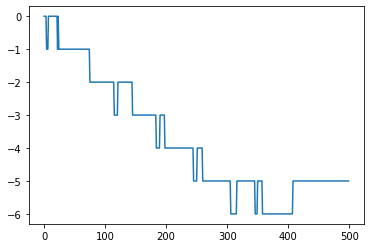

In [170]:
# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [171]:
id_gen = OrderIdGenerator()
valid_mask_array = valh.syntax_validation_matrix(v)
l = Message_Tokenizer.MSG_LEN

for _ in range(100):

    #losses = []
    #accs = []
    m_seq = valh.append_hid_msg(m_seq)

    idx = range(l)
    # reversed_idx = [i \
    #    for field_i in reversed(list(range(len(Message_Tokenizer.FIELDS)))) \
    #    for i in range(*LOBSTER_Dataset._get_tok_slice_i(field_i))]

    for mask_i in idx:# reversed_idx:
        # syntactically valid tokens for current message position
        valid_mask = valid_mask_array[mask_i]

        m_seq, _ = valh.mask_last_msg_in_seq(m_seq, mask_i)
        #print(m_seq[-20:])
        # inference
        input = (
            one_hot(
                jnp.expand_dims(m_seq, axis=0), vocab_len
            ).astype(float),
            jnp.expand_dims(b_seq, axis=0)
        )
        integration_timesteps = (
            jnp.ones((1, len(m_seq))), 
            jnp.ones((1, len(b_seq)))
        )
        logits = valh.predict(
            input,
            integration_timesteps, state, model, batchnorm)
        
        # filter out (syntactically) invalid tokens for current position
        #if valid_mask is not None:
        #    logits = valh.filter_valid_pred(logits, valid_mask)
        
        # TODO: remove - just for debugging
        #label = m_enc[end_i][mask_i]
        #losses.append(cross_entropy_loss(logits, label))
        #accs.append(compute_accuracy(logits, label))

        #print(m_seq[-20:])
        # update sequence
        # note: rng arg expects one element per batch element
        rng, rng_ = jax.random.split(rng)
        m_seq = valh.fill_predicted_toks(m_seq, logits, sample_top_n, jnp.array([rng_]))

    ### NEW:

    m_seq_raw = m.iloc[end_i - n_messages : end_i]
    order_id = id_gen.step()

    # parse generated message for simulator, also getting corrected raw message
    # (needs to be encoded and overwrite originally generated message)
    sim_msg, msg_corr = get_sim_msg(
        m_seq[-l:],
        m_seq,  # TODO: check if this should be the sequence without the generated msg
        m_seq_raw,
        sim,
        tok,
        v,
        new_order_id=order_id,
        tick_size=100
    )

    if sim_msg is None:
        print('invalid message - discarding...')
        # cut away generated message and pad begginning of sequence
        m_seq = onp.concatenate([
            onp.full((l,), Vocab.NA_TOK),
            m_seq[: -l]])
        continue

    # replace in sequence
    print('before', m_seq[-l:])
    print('after', msg_corr)
    m_seq = m_seq.at[-l:].set(msg_corr)

    # feed message to simulator, updating book state
    p_bid_old = sim.get_best_bid()
    _trades = sim.process_order(sim_msg)
    p_bid_new = sim.get_best_bid()
    p_change = (p_bid_new - p_bid_old) // tick_size

    # get new book state
    book = sim.get_L2_state()
    new_book = encode_L2_state(book, price_levels=(b_seq.shape[1] - 1))
    # prepend price jump to book state
    new_book = jnp.concatenate([jnp.array([p_change]), new_book])
    print('new_book', new_book.shape, new_book)
    # update book sequence
    b_seq = jnp.concatenate([b_seq[1:], jnp.expand_dims(new_book, axis=0)])


decoded predicted message: [5.18018029e+12 1.00000000e+00 2.00000000e+01 1.00000000e+00
 0.00000000e+00 5.00119763e+12 3.00000000e+00 1.00000000e+01
 5.00000000e+00 0.00000000e+00]
ORDER MODIFICATION
looking for perfect match
downsizing (event_type=3) order from 10 to 0 and setting type to 3
before [    8   183   183   289   606  1003  1207 11107 11008 11109     8     4
   200   632   985  1005  1107 11107 11012 11109]
after [    8   183   183   289   606  1003  1207 11107 11008 11109     8     4
   200   632   985  1005  1007 11107 11012 11109]
new_book (41,) [   0    0    0    0    0    0    0    0    0    0   50  750   50  490
  775 1250  500  600  782  802    0  182 1056  706 1100 1012  468 1615
  431    0   50    0    0    0    0    0    0    0    0    0    0]
decoded predicted message: [5.00519727e+12 1.00000000e+00 1.00000000e+01 5.00000000e+00
 0.00000000e+00            nan            nan            nan
            nan            nan]
NEW LIMIT ORDER
before [    8     8   200  

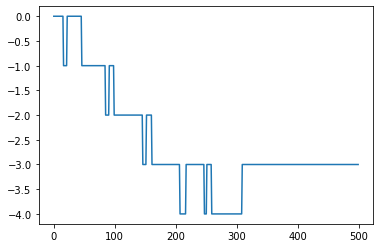

In [172]:
# inspect movement of best bid price for sequence including
# generated flow at the end

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [175]:
m_seq.reshape((-1,l))[-100:]

Array([[    8,   402,   426, ..., 11107, 11009, 11109],
       [    8,   183,   183, ..., 11107, 11012, 11109],
       [    8,     8,   200, ...,     2,     2,     2],
       ...,
       [    8,   200,     8, ...,     2,     2,     2],
       [    8,    22,   606, ..., 11107, 11011, 11109],
       [    8,   369,   512, ..., 11108, 11007, 11110]], dtype=int32)

In [179]:
decod_gen_msgs = tok.decode(m_seq.reshape((-1,l))[-100:], v)
decod_gen_msgs = pd.DataFrame(decod_gen_msgs, columns=Message_Tokenizer.FIELDS)
decod_gen_msgs

,time,event_type,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
0,5.399424e+12,1.0,10.0,2.0,0.0,5.399936e+12,3.0,10.0,2.0,0.0
1,5.180180e+12,1.0,20.0,1.0,0.0,5.001198e+12,3.0,0.0,5.0,0.0
2,5.005197e+12,1.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN
3,5.005006e+12,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
4,5.020982e+12,1.0,1.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
95,5.245201e+12,1.0,10.0,1.0,1.0,5.005604e+12,3.0,0.0,-0.0,1.0
96,5.197005e+12,1.0,10.0,-1.0,1.0,5.005961e+12,3.0,0.0,-3.0,1.0
97,5.197006e+12,1.0,1.0,-9.0,1.0,NaN,NaN,NaN,NaN,NaN
98,5.019604e+12,1.0,10.0,2.0,0.0,5.982982e+12,3.0,0.0,4.0,0.0


In [206]:
decod_gen_msgs.iloc[50:]

,time,event_type,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
50,5.286201e+12,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
51,5.603287e+12,1.0,10.0,1.0,0.0,5.007005e+09,3.0,0.0,2.0,0.0
52,5.603986e+12,1.0,0.0,-0.0,1.0,NaN,NaN,NaN,NaN,NaN
53,5.005982e+12,4.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
54,5.005005e+09,4.0,1.0,-0.0,1.0,NaN,NaN,NaN,NaN,NaN
55,5.020286e+12,1.0,2.0,2.0,0.0,5.019987e+09,3.0,0.0,-0.0,1.0
56,5.005198e+12,4.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
57,5.007198e+12,1.0,1.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
58,5.019644e+12,4.0,1.0,-0.0,1.0,NaN,NaN,NaN,NaN,NaN
59,5.007657e+09,1.0,1.0,-0.0,1.0,NaN,NaN,NaN,NaN,NaN


In [203]:
decod_gen_msgs['size'].value_counts().sort_index()

0.0     25
1.0     36
2.0      4
3.0      1
5.0      2
10.0    28
20.0     4
Name: size, dtype: int64

In [193]:
# new orders / executions
new_orders = decod_gen_msgs.loc[decod_gen_msgs.time_new.isna()]

<AxesSubplot:>

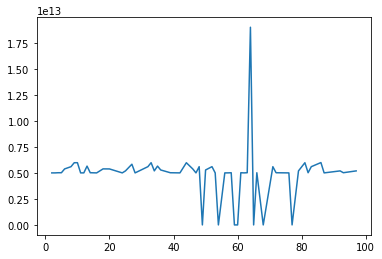

In [196]:
# error: should be monotone increasing
new_orders.time.plot()

In [194]:
new_orders.event_type.value_counts()

1.0    55
4.0     5
Name: event_type, dtype: int64

In [195]:
# only order modifications
modif_orders = decod_gen_msgs.dropna()

In [207]:
modif_orders.event_type_new.value_counts()

3.0    40
Name: event_type_new, dtype: int64

In [ ]:
modif_orders.

In [76]:
b_seq.shape

(500, 41)

In [68]:
test = jnp.arange(5)

In [73]:
jnp.concatenate([jnp.array([1]), test])

Array([1, 0, 1, 2, 3, 4], dtype=int32)

In [67]:
b_seq.shape

(500, 41)

In [64]:
encode_L2_state(sim.get_L2_state(), price_levels=40)

Array([   0,    0,    0,    0,    0,    0,    0,    0,    0,   50,  750,
         50,  490,  775, 1250,  500,  600,  782,  802,    0,  182, 1056,
        706, 1100, 1012,  468, 1615,  431,    0,   50,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [105]:
tok.encode_msg(msg_corr, v)

array([    8,     8,     8,     8,     8,  1003,  1017, 11107, 11008,
       11109])

In [64]:
m_seq[-40:]

Array([    8,   402,   426,   552,   519,  1003,  1107, 11107, 11009,
       11109,     8,   402,   938,   659,   860,  1005,  1107, 11107,
       11009, 11109,     8,     8,     8,     8,     8,  1003,  1107,
       11107, 11008, 11109,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2], dtype=int32)

In [65]:
m_seq[-20:]

Array([    8,     8,     8,     8,     8,  1003,  1107, 11107, 11008,
       11109,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2], dtype=int32)

In [102]:
accs

[Array([ True], dtype=bool)]

In [103]:
losses

[Array([0.02193826], dtype=float32)]

In [68]:
m_seq[-20:]

Array([    8,     8,     8,     8,     8,  1003,  1107, 11107, 11008,
       11109,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2], dtype=int32)

In [ ]:
# try multiple rolls to get valid message

In [ ]:
# TODO:

# sim_msg = get_sim_msg(
#     m_enc[end_i],
#     m_seq,
#     sim,
#     tok,
#     v,
#     new_order_id=42, tick_size=100
# )
# sim_msg

# sim.process_order(sim_msg)

In [69]:
tok.decode_to_str(m_seq[-20:], v)

array([['005', '005', '005', '005', '005', '1', '010', '+', '01', '0',
        'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN',
        'NAN']], dtype='<U3')

In [70]:
# decode predicted message
pred_msg = tok.decode(m_seq[-20:], v).flatten()
pred_msg

array([5.00500501e+12, 1.00000000e+00, 1.00000000e+01, 1.00000000e+00,
       0.00000000e+00,            nan,            nan,            nan,
                  nan,            nan])

In [69]:
v.DECODING_GLOBAL[980]

('time', '977')

In [71]:
valh.validate_msg(m_seq[-20:], tok, v)

True

In [74]:
sim.orderbook_array.shape

(2, 10, 20, 6)

In [76]:
# side: 0: asks 1: bids
sim.get_volume_at_price(0, 988000)

Array(0, dtype=int32)

In [77]:
# side: 0: asks 1: bids
sim.get_volume_at_price(1, 987000)

Array(50, dtype=int32)

In [78]:
sim.get_volume_at_price(0, 988500)

Array(1012, dtype=int32)

In [79]:
from gym_exchange import Config
from gymnax_exchange.jaxob.JaxOrderbook import INITID

In [80]:
sim.get_init_volume_at_price(0, 988500)

Array(174, dtype=int32)

In [81]:
sim.get_L2_state()

Array([988100,    182, 987900,    802, 988200,   1056, 987800,    782,
       988300,    706, 987700,    600, 988400,   1100, 987600,    500,
       988500,   1012, 987500,   1250, 988600,    468, 987400,    775,
       988700,   1615, 987300,    490, 988800,    431, 987200,     50,
       989000,     50, 987100,    750,     -1,      0, 987000,     50],      dtype=int32)

In [ ]:
# TODO: add functions to jorderbook.py

In [ ]:
def msg_to_raw(msg, bid_price, tick_size):
    """Convert message to raw data format."""
    assert len(msg) == 5
    # time
    msg[0] = msg[0] * 1e-9 + 9.5 * 3600
    # price
    msg[3] = bid_price + int(msg[3]) * tick_size
    # direction
    msg[4] = msg[4] * 2 - 1
    return msg

In [ ]:
# actual next message (not predicted and not part of seq)
m_enc[end_i]

array([    8,   402,   328,   183,   770,  1003,  1207, 11107, 11011,
       11109,     8,   403,     9,   666,   752,  1005,  1107, 11107,
       11010, 11109])

In [ ]:
#raw_seq = m.iloc[end_i - n_messages: end_i].copy()
#raw_seq.drop('order_id', inplace=True, axis=1)

In [301]:
test_msg = m_enc[end_i].copy()
print('correct', test_msg)
#test_msg[2] -= 1  # modify time
#test_msg[6] += 1  # modify size
#test_msg[8] += 1  # modify price
print('modified', test_msg)

correct [    8   402   328   183   770  1003  1207 11107 11011 11109     8   403
     9   666   752  1005  1107 11107 11010 11109]
modified [    8   402   328   183   770  1003  1207 11107 11012 11109     8   403
     9   666   752  1005  1107 11107 11010 11109]


In [85]:
# use generated message
test_msg = m_seq[-20:].copy()

In [102]:
m_seq_raw = m.iloc[end_i - n_messages : end_i]

id_gen = OrderIdGenerator()
order_id = id_gen.step()

sim_msg, raw_vals = get_sim_msg(
    test_msg,
    m_seq,
    m_seq_raw,
    sim,
    tok,
    v,
    new_order_id=order_id,
    tick_size=100
)
sim_msg

raw_vals
['005005005005005', '1', '0010', '+01', '0']


{'timestamp': '39205.005005005',
 'type': 1,
 'order_id': 88000004,
 'quantity': 10,
 'price': Array(988000, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

In [103]:
# TODO: do this for type 1, 4 messages as well

tok = Message_Tokenizer()
tok.encode_msg(raw_vals, v)

time 005005005005005
delim_i [3, 6, 9, 12]
1003
[8, 8, 8, 8, 8]

event_type 1
[1003]

size 0010
delim_i []
10003
[1017]

price +01
delim_i [1]
105
[11107, 11008]

direction 0
[11109]



array([    8,     8,     8,     8,     8,  1003,  1017, 11107, 11008,
       11109])

In [ ]:
sim.process_order(sim_msg)

[       5       -1       10   988200        0 32429970    39600  6663749]
[[[[      100    988000         0 276499246     39599 322500767]
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]
   ...
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]]

  [[      100    988100         0 276492538     39599 264867549]
   [       82    988100         0 276511822     39599 685781583]
   [       -1        -1        -1        -1        -1        -1]
   ...
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]]

  [[       81    988200         0 276491886     39599  26281485]
   [      100    988200         0 276500518     39599  33606933

(Array([[-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1]], dtype=int32),
 Array([       5,       -1,       10,   988200,        0, 32429970,
           39600,  6663749], dtype=int32))

In [ ]:
input[0].shape

(1, 10000, 11111)

In [ ]:
input[1].shape

(1, 500, 41)

In [ ]:
# TODO: refactor slightly and work in simulation step
#       and simulator matching orders

pred_n_messages = 1
valid_mask_array = valh.syntax_validation_matrix()
inf_seq = valh.pred_msg(
    start_seq,
    pred_n_messages,
    state,
    model,
    args.batchnorm,
    rng,
    valid_mask_array
)